In [1]:
import torch
from torchvision import transforms
from PIL import Image
import torch.nn as nn
import torchvision
import matplotlib.pyplot as plt
import numpy as np

import torch.nn.functional as F
import torch.optim as optim
import tqdm



In [2]:
import os
 
path = 'EuroSAT_RGB'
dir_list = os.listdir(path)
convert_tensor = transforms.ToTensor()

images = []
labels = []


for label in dir_list:
    path = 'EuroSAT_RGB/'+ label + '/'
    dir_list = os.listdir(path)
    for file in dir_list:
        img = Image.open(path+file)
        convert_tensor(img)
        images.append( convert_tensor(img))
        labels.append(label)



In [31]:
import numpy as np
from sklearn.model_selection import train_test_split

label_to_index = {label: index for index, label in enumerate(set(labels))}

label_indices = []

for label in labels:
    label_indices.append(label_to_index[label])

data_array = np.array(images)
labels_array = np.array(label_indices)

train_data, test_data, train_labels, test_labels = train_test_split(data_array, labels_array, test_size=0.2, random_state=1)


/var/folders/hg/kqg69xz568l28vnvcx6x09hh0000gn/T/ipykernel_44334/1049900653.py:11: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  data_array = np.array(images)
/var/folders/hg/kqg69xz568l28vnvcx6x09hh0000gn/T/ipykernel_44334/1049900653.py:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  data_array = np.array(images)


8


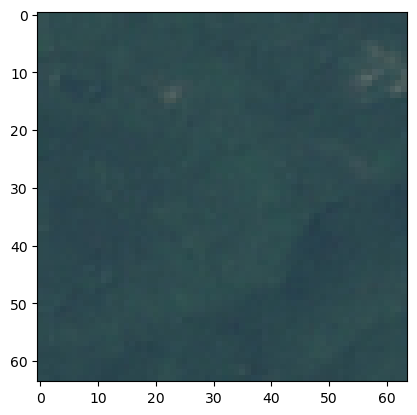

6


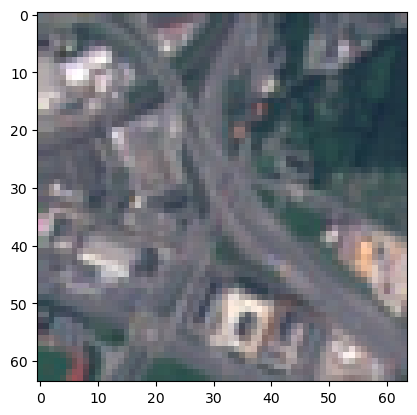

6


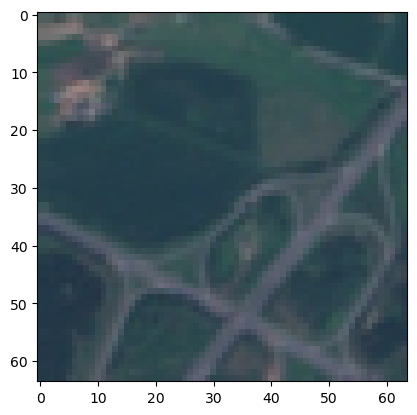

4


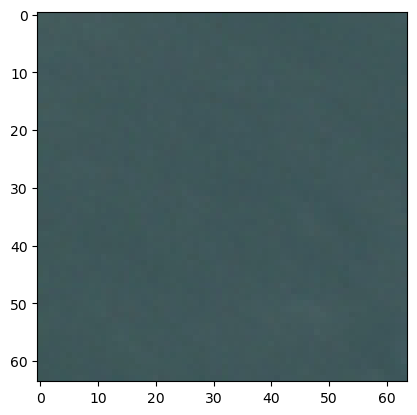

In [32]:

for i in range(1,5):
    print(train_labels[i])
    plt.imshow(train_data[i].permute(1, 2, 0))
    plt.show()


In [68]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 128, 3, 1)  # in_channels, out_channels, kernel_size, stride
        self.conv2 = nn.Conv2d(128, 64, 3, 1)
        self.dropout1 = nn.Dropout2d(0.25)  # Each channel gets zeroed out independently on each forward call with probability p
        self.dropout2 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(57600, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

net = Net()
print(net)

Net(
  (conv1): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout2d(p=0.25, inplace=False)
  (dropout2): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=57600, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


In [16]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters())



In [38]:
label_indices[1]

8

In [69]:
running_loss = 0.0
num_epochs = 1

for epoch in range(num_epochs):
    for i in range (0,len(train_data)):
        lbl = torch.tensor([train_labels[i]])
        img = train_data[i].unsqueeze(0)


        outputs = net(img)
        loss = criterion(outputs, lbl)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()


In [81]:
len(train_data)

21600

In [94]:
predicted_list = []

for i in range(len(test_data)):

    lbl = torch.tensor([test_labels[i]])

    img = test_data[i].unsqueeze(0)

    #plt.imshow(test_data[i].permute(1, 2, 0))
    test_outputs = net(img)
    _, predicted = torch.max(test_outputs, 1)

    predicted_list.append(int(predicted))

/Users/uditdhand/anaconda3/lib/python3.10/site-packages/torch/nn/functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


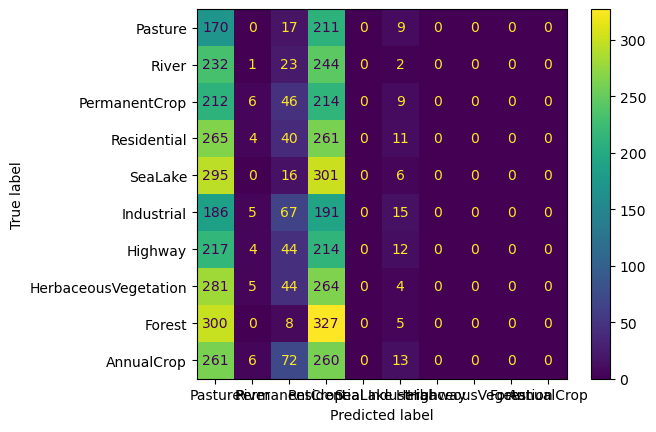

In [102]:
import sklearn.metrics as mt

mt.accuracy_score(y_pred=(predicted_list),y_true=test_labels)

mtx = mt.confusion_matrix(y_pred=(predicted_list),y_true=test_labels)

disp = mt.ConfusionMatrixDisplay(confusion_matrix = mtx, display_labels=label_to_index.keys())

disp.plot()